## TP1 M1 Images : Couleurs et contraste

**ENS Paris-Saclay**

**Département de Mathématiques**


---


**NOM et Prenom:**      Cornou Corentin, Déglise Marianne

---


## Consignes pour le rapport de TP

Ce TP comporte diverses questions. Les réponses, les résultats des expériences
(images, figures), ainsi que le code devront être contenus dans ce
notebook.

Il est possible de travailler en groupes de deux élèves (pas plus) ou individuellement.

Vous êtes également invité à rajouter toutes remarques ou commentaires sur les
résultats de votre code là où vous le jugerez nécessaire. Vous pouvez créer
une nouvelle cellule en cliquant sur l'icone **+ Code**. **Pensez à sauvegarder
régulièrement votre travail** (Fichier -> Enregistrer ou CTRL+S).

Le TP doit être soumis sur eCampus dans un délai de **deux semaines au plus tard**. \
 <font size="4"> <b>Une pénalité de <font color=red>deux points par
 jour</font> de retard sera appliquée </b>à partir de ce moment-là</font>. \
Le fichier joint doit être un notebook exécutable au format *ipynb* (dans
*Google Colab*, Fichiers -> Télécharger le fichier ipynb), intitulé
*nom_prenom_TP1.ipynb*.
Vous recevrez un accusé de soumission. Veuillez vous en assurer.

Avant d'envoyer votre TP, nous vous recommandons de cliquer sur
Exécution -> Tout exécuter.  Vérifier ensuite que l'ensemble du notebook ne
comporte pas d'erreurs.

<font color=red><b>Important</b></font> : si le travail est effectué en groupe, indiquer les noms des deux membres du groupe. En plus, il ne faut soumettre qu'un seul foi le notebook dans eCampus pour le group, <b>jamais individuellement deux fois le même</b>.

# Mise en route

Dans ce TP, nous étudirons les articles suivants :

- [Simplest Color Balance](http://www.ipol.im/pub/art/2011/llmps-scb/)
- [Multi-scale retinex](http://www.ipol.im/pub/art/2014/107/)

## Modules python et fichiers nécessaires

On commence par charger les images ainsi que les modules python nécessaires pour l'exécution du TP.


In [2]:
!wget -q https://gfacciol.github.io/afh/TP_M1_Images/TP1/math_books.jpg
!wget -q https://gfacciol.github.io/afh/TP_M1_Images/TP1/Aspect_ratio_4_3_example.jpg
!wget -q https://gfacciol.github.io/afh/TP_M1_Images/TP1/comp_SSR_MSR.jpeg 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io

plt.show()
plt.ion()

%matplotlib inline

In [4]:
#Gère le typage
import typing
Image = np.ndarray[np.ndarray]
RGB_Image = np.ndarray[np.ndarray[np.ndarray[float]]]
GreyScaleImage = np.ndarray[np.ndarray[float]]

Tensor = np.ndarray[np.ndarray[np.ndarray[float]]]

In [5]:
def plot_img(x : Image) -> None:
    """
    Affiche une image passée en entrée.
    """
    assert np.all(x >= 0) and np.all(x <= 1), "Les valeurs de l'image doivent être entre 0 et 1!"

    plt.imshow(x, vmin=0, vmax=1, interpolation="nearest", cmap='gray')
    plt.axis('off')
    plt.show()

In [6]:
def colorize(grey_scale_function : "callable[[GreyScaleImage],...]") -> "callable[[RGB_Image], ...]":
    """
    Transforme une fonction prenant en entrée une image en échelle de gris, en une autre prenant en entrée une image en couleur et appliquant la fonction
    en échelle de gris sur chaque composante de l'image RBG
    """
    def fun(img : RGB_Image) :
        split_RGB = (img[:,:,i] for i in range(3))
        processed_split_RGB = tuple(map(grey_scale_function, split_RGB))
        return np.dstack(processed_split_RGB)
    
    return fun

# 1. Simplest Color Balance

**Préambule 1 :** Parcourir l'article [Simplest Color Balance](http://www.ipol.im/pub/art/2011/llmps-scb/). En quelques phrases, décrire le problème que la méthode cherche à résoudre et décrire ce que fait l'algorithme. Vous distinguerez le cas des images en échelle de gris et en couleurs.

**Réponse :** Le but de cet algorithme est de corriger l'exposition des images. En supposant que les pixels à RGB faibles correspondent aux zones sombres et ceux aux RGB élevés aux zones très claires, l'idée est alors d'étendre linéairement l'échelle des coefficients au maximum afin de profiter au mieux de toute les échelles de luminosité. Avant cela on enlève les valeurs aberrantes qui sont déjà aux extrémités afin de permettre à la linéarité de fonctionner.

Dans le cas des images en échelle de gris, il suffit d'étendre l'intensité du gris linéairement. Pour les images en couleurs, on étend chacune des composantes R, G et B séparément.

**Préambule 2 :** Après lecture de l'article, pensez-vous que cette méthode puisse être utilisée pour

- (1) améliorer le contraste d'une image ?
- (2) assombrir une image très lumineuse ?
- (3) éclaircir une image sombre ?
- (4) équilibrer l'histogramme d'une image ?

Dans chaque cas, répondez par *'oui'* ou *'non'* et justifier très brièvement.


**Réponse :**
- (1) Oui, on étend à la fois vers les RGB faibles et les RGB élevés, qui correspondent à des zones très sombres et très claires.
- (2) Oui car on augmente les contrastes, donc les zones un peu plus sombres le seront beaucoup plus dans l'image modifiée
- (3) idem dans l'autre sens
- (4) Non, il étend l'histogramme mais n'en modifie pas la forme.

**Question 1 :** On va implémenter l'algorithme décrit dans la Section 3.1 de l'article et rappelé ci-dessous. Compléter le code de fonction `simplest_color_balance` en suivant les indications.
<div> <center> <img src=https://gfacciol.github.io/afh/TP_M1_Images/TP1/Algo1_easy.jpg width="450"/> </center> </div> <br>

In [7]:
def simplest_color_balance(img : GreyScaleImage, s1 : float, s2 :float) -> GreyScaleImage:
    """
    Implémentation de l'algorithme Simplest Color Balance.
    Args:
    - img (np.array): Une image.
    - s1 (float): Le pourcentage (entre 0 et 1) de valeurs à saturer par valeurs inférieures.
    - s2 (float): Le pourcentage (entre 0 et 1) de valeurs à saturer par valeurs supérieures.
    """
    # 1. Trier les valeurs de img
    sorted_values = [x for ligne in img for x in ligne]
    sorted_values.sort()
    # 2. Sélectionner les quantiles
    # NB: Si on a une erreur ici, c'est que 1. est mal fait !
    N = len(sorted_values)
    i1, i2 = round(N * s1), round(N * (1 - s2) - 1)
    vmin = sorted_values[i1]
    vmax = sorted_values[i2]
  
    # 3. Saturer les valeurs des pixels.
    # Les valeurs supérieures à vmax doivent être mises à vmax.
    # Les valeurs inférieures à vmin doivent être mises à vmin.
    saturated_img = np.copy(img)
    n,m = saturated_img.shape
    saturated_img = np.vectorize(lambda x : min(vmax,max(vmin,x)))(saturated_img)

    # 4. Transformation affine
    if vmin < vmax :
      print(vmax-vmin)
      return (saturated_img - vmin) / (vmax - vmin)
    else : 
      return saturated_img - vmin


**Question 2 :** Tester votre code sur l'image `math_books.jpg`. On affichera l'image à l'aide de la fonction `plot_img` définie au début du notebook.

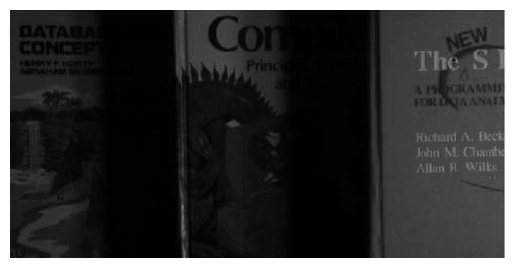

0.34901960784313724


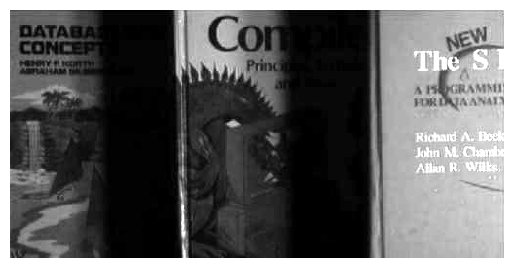

In [8]:
img = plt.imread('math_books.jpg') / 255
plot_img(img)
saturated_img = simplest_color_balance(img, .02, .02)
plot_img(saturated_img)

**Question 3 :** Quel est l'utilité des seuils $s_1$ et $s_2$ ? Que se passerait-t-il si l'on considère $s_1=0$ ou $s_2=0$ ?

**Réponse :** On supprime les valeurs aberrantes trop proches des extrémités pour pouvoir étendre correctement. (Sinon la linéarité est gâchée par ces valeurs qui diminuent grandement le potentiel d'étirement.)

**Question 4 :** Charger l'image `math_books.jpg` dans un numpy array `u` (**Attention, les valeurs doivent être entre 0 et 1 !**). Modifier le tableau `u` de sorte que si l'on y applique la fonction `simplest_color_balance` avec $s_1 = s_2= 1\%$, celle-ci renvoie l'identité.

Vérifier qu'il s'agit bien de l'identité.

In [9]:
# Charger l'image
u = plt.imread('math_books.jpg')/255

# On vérifie bien que ses valeurs sont entre 0 et 1.
assert np.all(u <= 1) and np.all(u >= 0), "Les valeurs doivent être entre 0 et 1 !"

# Modifier l'image
u = simplest_color_balance(u, 0.01, 0.01)

# Vérifier qu'il s'agit bien de l'identité (doit retourner True)
np.allclose(u, simplest_color_balance(u, 0.01, 0.01))

0.45098039215686275
1.0


True

**Question 5 :** Modifier la fonction `simplest_color_balance` de la question 2 pour implémenter la version RGB comme décrit à la Section 4.1 de l'article.

In [10]:
def simplest_color_balance_rgb(img : RGB_Image, s1:float, s2:float) -> RGB_Image:
    """
    Implémentation de l'algorithme Simplest Color Balance version RGB.
    Args:
    - img (np.array): Une image au format RGB.
    - s1 (float): Le pourcentage (entre 0 et 1) de valeurs à saturer par valeurs inférieures.
    - s2 (float): Le pourcentage (entre 0 et 1) de valeurs à saturer par valeurs supérieures.
    """
    return colorize(lambda x :simplest_color_balance(x,s1,s2))(img)

<br> <div> <center> <img src=https://gfacciol.github.io/afh/TP_M1_Images/TP1/4_tiers_16_neuvieme.jpeg width="1000"/> </center> </div> <br>

**Question 6 :** Vous disposez d'une image 4:3 que vous souhaitez afficher sur un écran 16:9. Ceci oblige l'ajout de bandes noires comme sur l'exemple ci-dessus. Déduire de la question 4 s'il convient ou non d’appliquer `simplest_color_balance` avant ou après l’ajout de bandes noires. Dire pourquoi.

**Réponse :** Il faut appliquer l'algorithme avant sinon les bandes noires empêcheront le bon calcul de vmin et vmax, et les valeurs aberrantes de la photos ne seront pas supprimées, ce qui empêchera la bonne linarisation.

**Question 7 :** L'objet de cette question est de vérifier votre réponse à la question 4. Charger l'image `Aspect_ratio_4_3_example.jpg` dans un tableau `u`. Cette image a un format 4:3. Écrire une fonction `zero_pad` qui prend en argument un image `img` de format 4:3 et renvoie une image, d'un format 16:9, contenant intégralement `img` et deux bandes noires, égales, sur chaque côté.

Tester la fonction `zero_pad` sur l'image. On affichera les résultats à l'aide de la fonction `plot_img`.

Puis, calculez :
- Ce que l'on obtient en appliquant `simplest_color_balance` puis `zero_pad`.
- Ce que l'on obtient en appliquant `zero_pad` puis `simplest_color_balance`.
- Commentez les résultats obtenus et les différences observées.

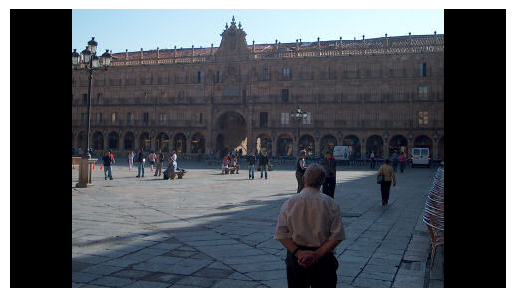

0.8666666666666666
0.9529411764705882


0.9294117647058824


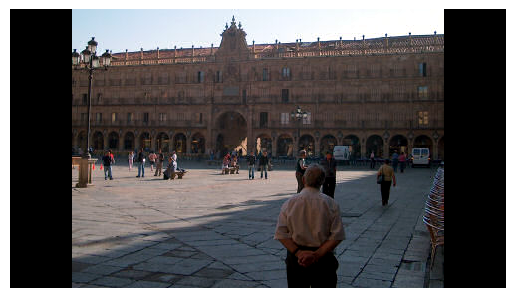

0.8784313725490196
0.9803921568627451
1.0


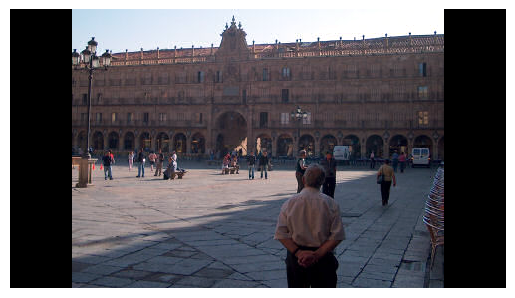

In [11]:
def zero_pad(img : Image)-> Image:
    """
    Prends une image au format 4:3 en entrée et ressort une image au format 16:9.
    """
    n,m,_ = img.shape
    ajout = m//6
    mod_img = np.zeros((n, m+2*ajout, 3))
    mod_img[:,ajout:-ajout,:] = img[:,:,:] 
    return mod_img

# Charger l'image Aspect_ratio_4_3_example.jpg (attention, valeurs entre 0 et 1 obligatoires !)
u = plt.imread('Aspect_ratio_4_3_example.jpg') / 255

# Tester la fonction zero_pad sur l'image (on utilisera plot_img pour afficher)
padded_u = zero_pad(u)
plot_img(padded_u)

# Appliquer simplest_color_balance puis zero_pad
mod_pad_u = zero_pad(simplest_color_balance_rgb(u,0.02,0.02))
plot_img(mod_pad_u)

# Appliquer zero_pad puis simplest_color_balance
pad_mod_u = simplest_color_balance_rgb(padded_u, 0.02, 0.02)
plot_img(pad_mod_u)


**Réponse :** L'image obtenue en appliquant d'abord 'zero_pad' puis 'simplest_color_balance_rgb' ne diffère pas beaucoup de l'image sur laquelle on a uniquement appliqué 'zero_pad', là où l'image obtenue en appliquant 'simplest_color_balance_rgb' puis 'zero_pad' est plus détaillée notamment dans les tons sombres (on peut observer en particulier la chemise de l'homme sur la photo dont les nuances apparaissent plus clairement ).

**Question 8 :** Précédemment, vous avez créez un "cas d'école" où la fonction `simplest_color_balance` échoue. Trouvez

- un autre exemple réel où la fonction `simplest_color_balance` échoue
- un exemple réel où la fonction `simplest_color_balance` réussit

Dans chaque cas, vous chargerez l'image de votre choix, vous l'afficherez et vous justifierez pourquoi la fonction `simplest_color_balance` échoue ou réussit.

*Note : Si vous ne parvenez pas à trouver d'exemples, vous pourrez toujours essayer de décrire quels types d'images seraient de bons candidats à faire échouer ou réussir la méthode.*

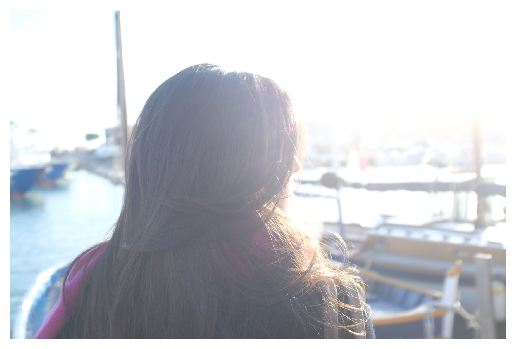

0.6745098039215687
0.6666666666666667
0.6352941176470588


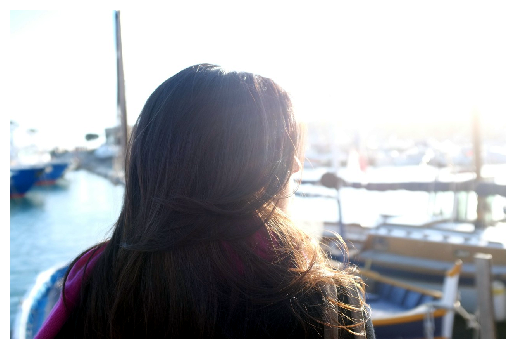

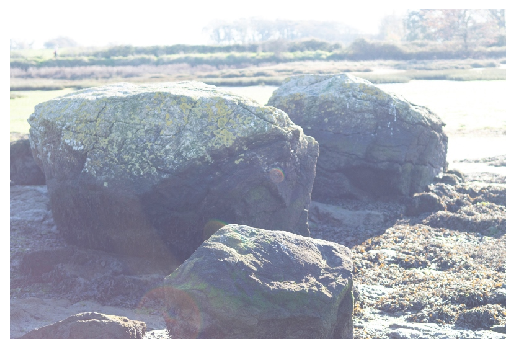

0.6235294117647059
0.615686274509804
0.5372549019607843


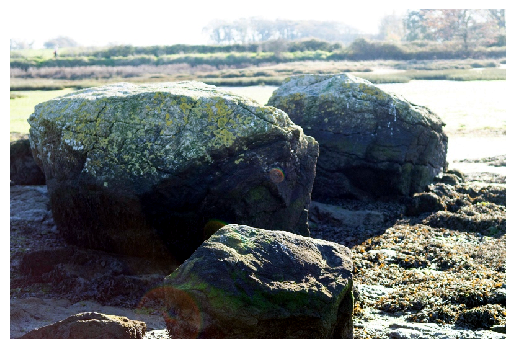

In [12]:
#crédits : https://contrastephoto.fr/wp-content/uploads/2020/11/Moktar_Photo_Surexpose-2.jpg
u = plt.imread("surex.jpg") /255
plot_img(u)
plot_img(simplest_color_balance_rgb(u, .02, .02))

#crédits : https://contrastephoto.fr/wp-content/uploads/2020/11/Moktar_Photo_Surexpose-2.jpg
u = plt.imread("rochers.jpg") /255
plot_img(u)
plot_img(simplest_color_balance_rgb(u, .02, .02))


**Réponse :** Dans la première image (la femme de dos) seuls les cehveux de la femme ont été corrigés, la partie plus claire de l'image l'ayant à peine été car l'histogramme s'est beaucoup plus étiré vers les ton sombres.

Dans la seconde image, l'éclairage est "uniformément" trop clair, l'algortihme parvient donc à corriger la surrexposition dans les clairs.

**Question 9 :** Pour une image couleur, expliquer (très brièvement) la différence entre les versions *RGB* (Section 4.1) et *IRGB* (Section 4.2).

**Réponse :** Dans la version RGB, on applique simplest_color_balance sur chacune des composantes couleurs R, G et B indépendamment. Cependant comme les échelles linéaires des trois couleurs peuvent alors différer, cette méthode risque de modifier les couleurs. Si l'on souhaite vraiment conserver les bonnes couleurs, la méthode IRGB permet de conserver les ratios R/G/B en appliquant simplest_color_balance sur la en échelle de gris de l'image (chaque pixel vaut R+G+B/3) pour corriger l'intensité de l'image, mais pas les ratios de couleur.

# 2. Multi-scale retinex

**Question 10 (Préambule) :** Lire le début de l'article [Multi-scale retinex](http://www.ipol.im/pub/art/2014/107/) (jusqu'à la section 2, incluse). En quelques phrases, décrire la différence entre Simplest Color Balance et Multi-scale retinex. Quelle méthode vous semble la plus performante et pourquoi ?

**Réponse :** Simplest Color Balance a une approche globale à la modification de la luminosité, en changeant linéairement les canaux de couleurs ou d'intensité. A l'inverse Multi-scale retinex permet de modifier la luminosité à l'échelle locale en changeant les valeurs d'un pixel selon la moyenne des intensités rencontrées sur des chemins menant à ce pixel. Cette méthode semble plus efficace car elle permet de réhausser la luminosité de zones très sombres sans avoir à le faire sur toute l'image, ce qui évite de trop éclaircir le fond lorsque l'on veut retrouver les détails d'une photo prise à contre-jour par exemple.

## 2.1 Questions théoriques

**Question 11 :** Pourquoi utilise-t-on un flou Gaussien dans l'implémentation de Retinex étudié dans cet article ?






**Réponse :** On moyenne les valeurs des pixels voisins choisis avec une distribution gaussienne pour ne pas prendre en compte tous les pixels de manière égale, mais de plutôt se concentrer sur les voisins proches afin d'avoir des modifications de luminosité locales.

**Question 12 :**  Lorsqu'on considère l'algorithme Single-scale, le choix de $\sigma$ est-il important ? Justifiez.



**Réponse :** Le choix de $\sigma$ est très important car il détermine le choix qui est fait entre le rendu des couleurs et le rendu des détails de l'image

**Question 13 :**  Quel est la différence entre *single-scale* et *multi-scale retinex* ? Quel est l'avantage de *multi-scale* par rapport à *single-scale* retinex ?


**Réponse :** Multi-scale retinex fait une moyenne pondérée de plusieurs Single-scale retinex pour éviter d'avoir à faire un choix entre rendu des couleurs et des contrastes.

<br> <div> <center> <img src=https://gfacciol.github.io/afh/TP_M1_Images/TP1/comp_SSR_MSR.jpeg width="700"/> </center> </div> <br>


**Question 14 :** En analysant la Figure 2 de l'[article](http://www.ipol.im/pub/art/2014/107/), et particulièrement en comparant les trois résultats de single-scale retinex avec $\sigma=15,80,250$ avec le résultat de multi-scale rétinex, l'usage des valeurs  par défaut $\sigma_1=15, \sigma_2=80, \sigma_3=250$ vous semble-t-il approprié ? Justifiez.

**Réponse :** On voit que $\sigma = 15$ conserve les détails de l'image, mais perd les couleurs, et que c'est l'inverse pour $\sigma = 250$ (dans les arbres par exemple). Single-scale retinex avec $\sigma = 80$ est un bon compromis comme il est dit dans l'article, mais les couleurs ne sont toujours pas parfaites. Moyenner ces trois résultats avec Multi-scale retinex permet donc de profiter à la fois des détails de $\sigma = 15$ et des couleurs de $\sigma = 250$. $\sigma = 80$ est là pour que la moyenne ait un rendu uniforme en permettant d'avoir une bonne base sur laquelle appliquer ensuite les détails et les couleurs des deux autres single-scale retinex.

## 2.2 Questions  pratiques

Dans cette section, on va implémenter l'algorithme MSR décrit en page 9 de l'article et que l'on rappelle ci-dessous :
<br> <div> <center> <img src=https://gfacciol.github.io/afh/TP_M1_Images/TP1/algo_retinex.png width="500"/> </center> </div> <br>

**Question 15 :** Calculer le résultat de la convolution d'une image par un noyau de flou Gaussien. Pour ce faire, il est nécessaire d'effectuer cette opération dans le domaine de Fourier.

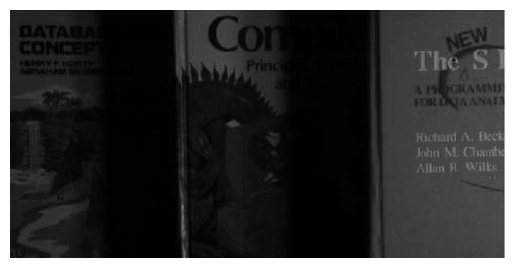

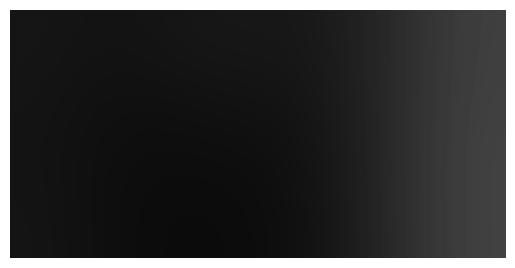

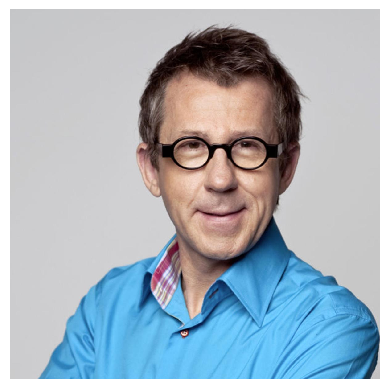

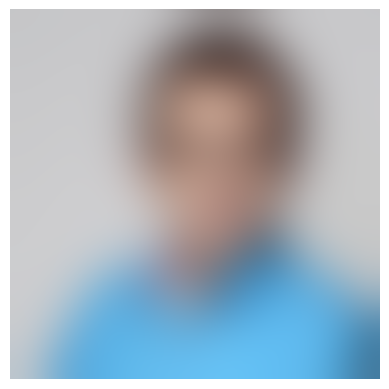

Ellipsis

In [89]:
def miroir(img : Image) -> Image:
  """
  Calcule la symmétrisation miroir de l'image d'entrée.
  """
  H, W, *C = img.shape
  img_sym = np.zeros((2 * H, 2 * W, *C))
  img_sym[:H, :W] = img
  img_sym[H:, :W] = img[::-1]
  img_sym[:H, W:] = img[:, ::-1]
  img_sym[H:, W:] = img[::-1, ::-1]

  return img_sym

def noyau_gaussien_fourier(H : int, W : int, sigma : float) -> np.ndarray:
  """
  Calcule la transformée de Fourier d'un noyau Gaussien.
  """
  xrng = np.fft.fftfreq(H)
  yrng = np.fft.fftfreq(W)
  xx, yy = np.meshgrid(xrng, yrng)

  return np.exp(-(2 * np.pi * sigma) ** 2 * (xx ** 2 + yy ** 2) / 2)

def _pre_bound(x :float) -> float:
  return x*(0<x and x<=1 ) + (x>1)
bound = np.vectorize(_pre_bound ) #fonction d'arrondi pour éviter les erreurs dues au calcul de la FFT

def bound(img : Image) ->Image :
  min, max = np.min(img), np.max(img)
  if min == max :
    return img
  elif max >1 and min<0:  return (img-min + 1e-17)/(max-min)
  elif max >1 : return (img-min + 1e-17)/(max-min) + min
  else : return max*(img-min + 1e-17)/(max-min)


def greyscale_gaussian_conv(img : GreyScaleImage, sigma: float) -> GreyScaleImage:
  """
  Calcule la convolution d'une image en niveau de gris `img` par un noyau gaussien d'écart type `sigma`.
  """
  u = miroir(img)
  H,W = u.shape
  F = np.fft.fft2(u)
  G = F* noyau_gaussien_fourier(W,H,sigma)
  G= np.fft.ifft2(G)
  return np.real(crop(G))

def gaussian_conv(img : RGB_Image, sigma: float) -> RGB_Image:
  """
  Calcule la convolution d'une image RGB `img` par un noyau gaussien d'écart type `sigma`.
  """
  return colorize(lambda x :greyscale_gaussian_conv(x,sigma))(img)



def crop(img : Image) -> Image:
  """
  Désymmétrise une image.
  """
  H,W = img.shape
  return img[:H//2, :W//2]


u = plt.imread("math_books.jpg")/255
plot_img(u)
plot_img(greyscale_gaussian_conv(u,80))

u = plt.imread("Jamy.jpg")/255
plot_img(u)
plot_img(gaussian_conv(u, 80))
...

**Question 16 :** Ecrire une fonction qui calcule l'étape "Single Scale Retinex" de l'algorithme MSRCR. On notera que comme l'écart type des noyaux gaussiens est le même pour tous les canaux couleurs, on peut se passer dans la boucle sur les canaux couleurs.


In [87]:
def single_scale_retinex(img : RGB_Image, sigma : float, epsilon : float = 1e-17) -> Tensor:
  """
  Calcule l'étape `Single Scale Retinex` de l'algorithme MSRCR.
  Prends une image RGB en entrée et ressort un tenseur de même dimension en sortie.
  """
  #n,m,_ = img.shape
  #diff=[]
  #for i in range(n):
  #  diffi = []
  #  for j in range(m):
  #    diffij = []
  #    for c in range(3):
  #      diffij.append(np.log(img[i][j][c]) - np.log(img[i][j][c] * np.exp(-(i**2 + j**2)/(2 * sigma**2))/(2 * np.pi * sigma**2)))
  #    diffi.append(diffij)
  #  diff.append(diffi)
  #f = np.vectorize(lambda x: max(10**(-17), x))
  u = np.copy(img)
  Diff  = (np.log10(u + epsilon) - np.log10(gaussian_conv(u, sigma)+epsilon))
  return np.array([Diff[:,:,i] for i in range(3)])


import cv2
def singleScaleRetinex(img,variance):
  retinex = np.log10(img +1e-17) - np.log10(cv2.GaussianBlur(img, (0, 0), variance)+1e-17)
  return retinex




**Question 17 :** En utilisant la fonction `single_scale_retinex` codée à la fonction précédente, implémenter l'étape "MultiScale Retinex" de l'algorithme.

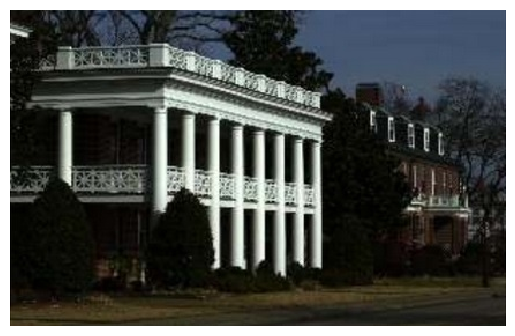

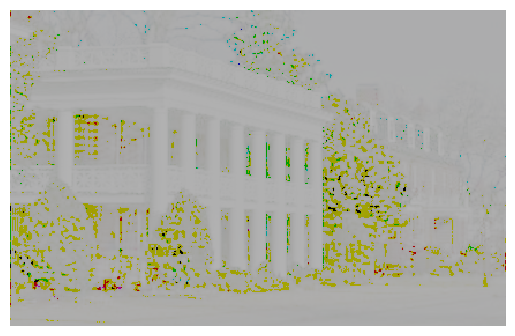

1.9779045684913952
1.8440510811807038
16.85700882832266


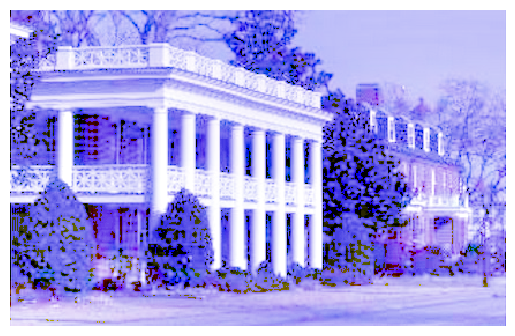

2.0546898880407363
1.8979479135196273
16.95266883477442


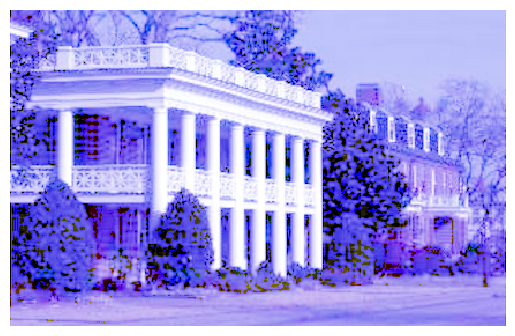

1.68696111760773
1.5453299525262492
16.494752675901495


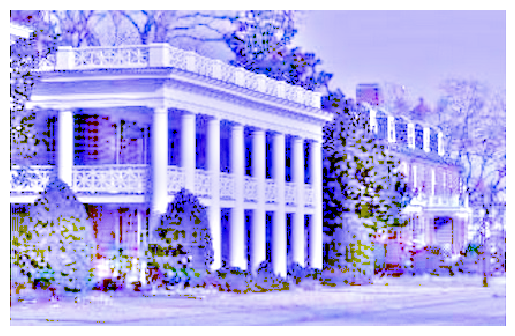

In [90]:
def multi_scale_retinex(img : RGB_Image, sigma1 : float, sigma2 : float, sigma3 : float) -> Tensor :
  """
  Calcule l'étape `MultiScale Retinex` de l'algorithme MSRCR.
  Prends une image RGB en entrée et ressort un tenseur de même dimension en sortie.
  """
  #diff1, diff2, diff3 = single_scale_retinex(img, sigma1), single_scale_retinex(img, sigma2), single_scale_retinex(img, sigma3)
  #n,m,_ = img.shape
  #msr = []
  #for i in range(n):
  #  msri = []
  #  for j in range(m):
  #    msrij = []
  #    for c in range(3):
  #      msrij.append((diff1[i][j][c] + diff2[i][j][c] + diff3[i][j][c])/3)
  #    msri.append(msrij)
  #  msr.append(msri)
  #return np.array(msr)
  return (single_scale_retinex(img, sigma1) + single_scale_retinex(img, sigma2) + single_scale_retinex(img, sigma3))/3

u = plt.imread("comp_SSR_MSR.jpeg") /255
v =np.dstack((multi_scale_retinex(u, 15, 80,250)))

plot_img(u)
plot_img(bound(v))
for s in {15,80,250} : plot_img(bound(simplest_color_balance_rgb(np.dstack(single_scale_retinex(u, s)), .02,.02)))



**Question 18 :** En utilisant la fonction `multi_scale_retinex`, implémenter l'étape "Color Restoration". On rappelle que `img.sum(-1, keepdims=True)` appliqué à une image RGB calcule $I_R + I_G + I_B$.

In [61]:
def color_restoration(img : RGB_Image, msr : Tensor, epsilon :float = 1e-17) -> Tensor:
  """
  Calcule l'étape `Color Restoration` de l'algorithme MSRCR.
  Prends une image RGB en entrée, un tenseur `msr` de même dimension,
  et retourne un tenseur de la même dimension que l'image RGB.
  """
  #n,m,_ = img.shape
  #msrcr = []
  #for i in range(n):
  #  msrcri = []
  #  for j in range(m):
  #    msrcrij = []
  #    for c in range(3):
  #      msrcrij.append(msr[i,j,c] * np.log(125*img[i,j,c]) - np.log(img.sum(-1, keepdims=True)))
  #    msrcri.append(msrcrij)
  #  msrcr.append(msrcri)
  #return np.array(msrcr)
  I_sum = np.log(img[:,:,0] + img[:,:,1] + img[:,:,2] +epsilon )
  return np.array([ 
    msr[i] *  (np.log((125*img[:,:,i]) +epsilon ) - I_sum)
    for i in range(3)]) # 



**Question 19 :** En utilisant les fonctions `multi_scale_retinex`, `color_restoration` et `simplest_color_balance` implementées précédemment, implémenter l'algorithme MSRCR.

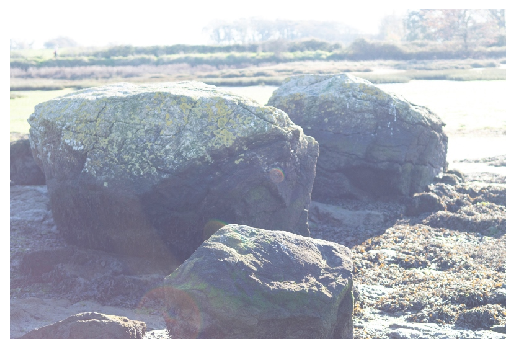

0.6313725490196078
0.6274509803921569
0.5450980392156863


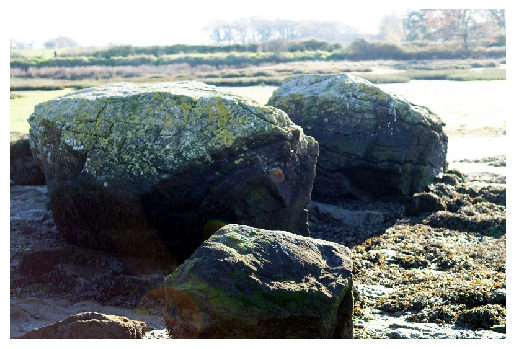

1.411496792337421
1.3163630473599683
1.0738376870496547


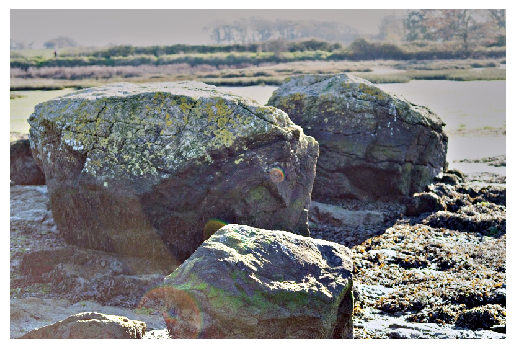

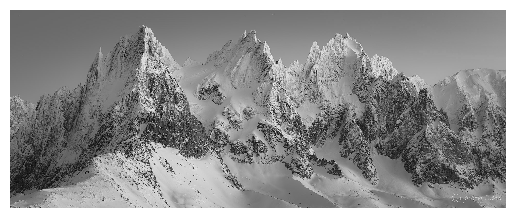

0.6901960784313725
0.6901960784313725
0.6901960784313725


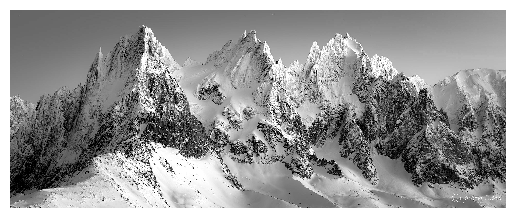

2.442015933327956
2.442015933327956
2.442015933327956


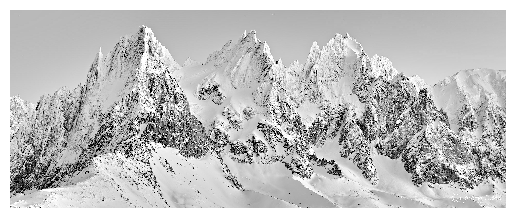

Ellipsis

In [92]:
def MSRCR(img : Image, sigma1  :float, sigma2 : float, sigma3 :float, s1 : float, s2 :float) -> Image:
  """
  Implémentation de l'algorithme MSRCR.
  """
  msrcr = color_restoration(img, multi_scale_retinex(img, sigma1, sigma2, sigma3))
  #n,m,_ = img.shape
  #out = []
  #for i in range(n):
  #  outi = []
  #  for j in range(m):
  #    outij = []
  #    for c in range(3):
  #      outij.append(simplest_color_balance_rgb(msrcr, s1, s2))
  #    outi.append(outij)
  #  out.append(outi)
  #return np.array(out)
  a  = (np.dstack(msrcr))
  return bound(simplest_color_balance_rgb(a, s1, s2))

u = plt.imread('rochers.jpg') /255
plot_img(u)
plot_img(simplest_color_balance_rgb(u,.01,.01))
plot_img(bound(MSRCR( u,15,80,250, .01,.01 )))

v = plt.imread('montagne.jpg')/255
v = np.dstack((v,np.copy(v),np.copy(v)))
plot_img(v)
plot_img(simplest_color_balance_rgb(v,.02,.02))
plot_img(bound(MSRCR( v,15,80,250, .02,.02 )))

# Testez votre fonction sur l'image math_books.jpg et affichez le résultat
...

**Question 20 :** Combien de temps avez-vous mis à faire ce TP ? (pas de mauvaise réponse, les détails sont appréciés)

**Réponse :** 5 heures environ (2 heures en tp et puis 3 heures pour le finir, il restait multi-scale retinex à faire et quelques corrections dans simplest color balance)

# 3. *(BONUS)* Image Color Cube Dimensional Filtering and Visualization

L'objectif de cette section est d'étudier l'article [suivant](http://www.ipol.im/pub/art/2011/blm-cdf/). Dans cette partie, vous n'avez rien à coder. Vous pouvez répondre aux questions directement après lecture de l'article. Nous vous encourageons vivement à tester la méthode via la [démo ipol](https://ipolcore.ipol.im/demo/clientApp/demo.html?id=43) ou en regardant l'[archive](https://ipolcore.ipol.im/demo/clientApp/archive.html?id=43).

![img](https://gfacciol.github.io/afh/TP_M1_Images/TP1/color_cube.jpeg)

**Question B1 :** Que représente le *color cube* d’une image couleur ? d'une image en échelle de gris ? d'une image avec tirage sépia (voir figure ci-dessus) ?



**Réponse :** LE color cube d'une image couleur représente l'ensemble des couleurs d'une image représentée dans $N^3$ où les trois coordonnées des points représentent les coefficients R, G et B de la couleur. Pour une image en échelle de gris, les points sont tous sur la diagonale de cube allant de (0,0,0) (noir) à (255,255,255)(blanc). Pour le tirage sépia, on garde la composant rouge et on met les autres composantes en échelle de gris, donc les points sont sur la diagonale de cube ou bien vont vers l'arête du rouge. Les points auront des coordonnées (r,m,m) avec r>m ou (m,m,m) sinon.

**Question B2 :**  On considère une image du drapeau français, d'abord synthétique, ne comportant que 3 couleurs pures et ensuite une photographie réelle du drapeau français. Dans chacun des cas, décrire à quoi ressemble le *color cube* de ces images.


**Réponse :** Pour l'image synthétique, il n'y a que trois couleurs : Bleu (0, 38, 84), Blanc (255, 255, 255) et Rouge (237, 41, 57). Le cube n'aura que trois points, sur ces trois ensembles de coordonnées. Pour la photographie, les transitions se font continûment, donc il y a des points qui suivient une ligne/bande reliant les points rouge et blanc et les points blanc et bleu.

**Question B3 :** Pourquoi est-il raisonnable de supposer que le *color cube* d’une image en couleur générique sera formé de morceaux de surface ?

**Réponse :** Sur une image en couleur générique, les transitions entre couleurs sont toujours graduelles, donc toutes les couleurs entre la couleur de deux zones voisines apparaîtront, ce qui formera une surface dans le color cube.